# Classiq Challenge - Quantum Arithmetics

Welcome to the Classiq challenge of the 2024 MIT IQuHack hackathon!
This Jupyter notebook is the framework for the challenge and you should follow it in order to solve it using Classiq (alongside the guidelines of the challenge).

The notebook has 3 parts:
1. A warm up session, just to get up to speed with a small example of Classiq
2. The challenge itself, including what you need to create, what's the format, and how you can check yourself
3. A cheat sheet with relevant Classiq functions declarations

Additional resources you should use are
- The IDE of the classiq platform at [platform.classiq.io](platform.classiq.io)
- The [community Slack of Classiq](https://short.classiq.io/join-slack) - Classiq's team will answer any question you have over there, including implementation questions
- [Classiq's documentation](https://docs.classiq.io/latest/user-guide/platform/) with the dedicated [Python SDK explanations](https://docs.classiq.io/latest/user-guide/platform/qmod/python/functions/)

Good luck!

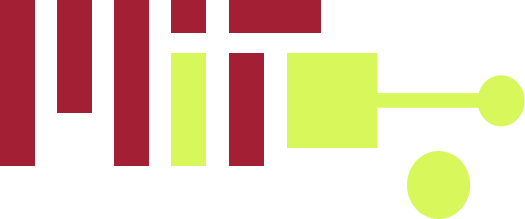

## Warm Up

Firstly, if you haven't done so far, you need to install the Classiq SDK package: 

!pip install -U classiq
!pip freeze > requirements.txt

and to authenticate your device against the Classiq backend:

In [ ]:
import classiq
classiq.authenticate()

/root/venv/lib/python3.10/site-packages/classiq/_internals/authentication/token_manager.py:82: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


Let's create a uniform superposition of numbers in the domain $[0,1)$ with equal spacing of $\frac{1}{2^{K-1}}$ for $K=5$:

Initializes $K$ qubits such that each qubit $\left|i\right>$ represents $x\in\{0,\frac{1}{2^K}, \frac{2}{2^K}, \ldots \frac{k}{2^K} \}$

In [ ]:
from classiq import *
K =5

@QFunc
def main(x:Output[QNum]):
    
    allocate_num(num_qubits=K, is_signed=False, fraction_digits=K,out=x)
    # puts all qubits into a superposition of states
    hadamard_transform(x)

quantum_model = create_model(main)
quantum_program = synthesize(quantum_model)

show(quantum_program) # view the circuit in the IDE

job = execute(quantum_program)
job.open_in_ide() # view the resulted histogram in the IDE

Opening: https://platform.classiq.io/circuit/25e15e35-1698-4d69-812a-ce5e9003dbe6?version=0.36.1


That's cool right? :)

If you are more a Python person, this is how you can post-process your results:

In [ ]:
results = job
parsed_counts = results.result()[0].value.parsed_counts
sorted_counts = sorted(parsed_counts, key=lambda x: x.state["x"])
for state_counts in sorted_counts: print('State: ', state_counts.state, '| Shots: ', state_counts.shots)

State:  {'x': 0.0} | Shots:  67
State:  {'x': 0.03125} | Shots:  64
State:  {'x': 0.0625} | Shots:  67
State:  {'x': 0.09375} | Shots:  64
State:  {'x': 0.125} | Shots:  63
State:  {'x': 0.15625} | Shots:  64
State:  {'x': 0.1875} | Shots:  47
State:  {'x': 0.21875} | Shots:  77
State:  {'x': 0.25} | Shots:  63
State:  {'x': 0.28125} | Shots:  59
State:  {'x': 0.3125} | Shots:  71
State:  {'x': 0.34375} | Shots:  78
State:  {'x': 0.375} | Shots:  67
State:  {'x': 0.40625} | Shots:  62
State:  {'x': 0.4375} | Shots:  58
State:  {'x': 0.46875} | Shots:  71
State:  {'x': 0.5} | Shots:  65
State:  {'x': 0.53125} | Shots:  75
State:  {'x': 0.5625} | Shots:  68
State:  {'x': 0.59375} | Shots:  48
State:  {'x': 0.625} | Shots:  50
State:  {'x': 0.65625} | Shots:  57
State:  {'x': 0.6875} | Shots:  59
State:  {'x': 0.71875} | Shots:  60
State:  {'x': 0.75} | Shots:  63
State:  {'x': 0.78125} | Shots:  67
State:  {'x': 0.8125} | Shots:  61
State:  {'x': 0.84375} | Shots:  66
State:  {'x': 0.875

## The Challenge Itself

### Imports

In [ ]:
# All the imports needed
from classiq import *

from classiq.interface.backend.backend_preferences import ClassiqBackendPreferences
from classiq.interface.executor.execution_preferences import ExecutionPreferences
from classiq.interface.model.model import Model as Model_Designer

import numpy as np
import json

In [ ]:
def print_depth_width(quantum_program):
    generated_circuit = GeneratedCircuit.parse_obj(json.loads(quantum_program))
    print(f"Synthesized circuit width: {generated_circuit.data.width}, depth: {generated_circuit.transpiled_circuit.depth}")

### The Heart of the Code - Build Your Algorithm Here

In [ ]:
# not this one
from classiq.builtin_functions import AmplitudeLoading
@QFunc
def compute_tanh(x: QNum, y: Output[QNum]):    
    a = AmplitudeLoading(
    size=3,
    expression="1/x",
    )
    y|= a(x) 

# Your precision value
precision = 4

@QFunc
def main(x: Output[QNum],y: Output[QNum]):
    
    # A quantum variable which represents numbers is initialized
    allocate_num(num_qubits=precision,      
                is_signed=False,            
                fraction_digits=precision,
                out=x)
    
    # Initalizing over all possible values of the quantum number with the hadamard transform
    hadamard_transform(x)
    # Computing your compute_tanh function
    compute_tanh(x,y)

# Generating the model itself
qmod = create_model(main)
qmod = set_constraints(qmod,Constraints(max_width=30,max_depth=30000, optimization_parameter='depth'))
qprog = synthesize(qmod)
print_depth_width(qprog)
# show(qprog)

TypeError: 'AmplitudeLoading' object is not callable

In [ ]:
# The heart of the code - the function that calculates the hyperbolic tangent
@QFunc
def compute_tanh(precision: QParam[int],    # The precision of x and tanh_x - how many fraction digits will represent your solution
                 x: QNum,                   # A quantum variable that is represents numbers
                 tanh_x: Output[QNum]       # The output of the function, which means it needs to be initialized within the scope of the function
                 ):
    
    # throws error because of no cloning theorem
    # tanh_x |= x

    # Pade approximation;
    # does not work; division of quantum numbers not supported (maybe figure out workaround?)
    # tanh_x |= x*( (27 + x**2) * (27 + 9*x**2) **(-1) )

    # Taylor series approximation;
    # does not work; needs way too many auxilliary qubits 
    #tanh_x |= x - ( (x**3)*(1/3) ) + ( (x**5)*(2/15) )
    # too many 

    # Linear approximation using minimized RSS
    #tanh_x |= 0.7*x+0.05

    tanh_x |= 0.774492*x+0.046076

# Your precision value
precision = 4

@QFunc
def main(x: Output[QNum],y: Output[QNum]):
    
    # A quantum variable which represents numbers is initialized
    allocate_num(num_qubits=precision,      
                is_signed=False,            
                fraction_digits=precision,
                out=x)
    
    # Initalizing over all possible values of the quantum number with the hadamard transform
    hadamard_transform(x)

    # Computing your compute_tanh function
    compute_tanh(precision,x,y)

# Generating the model itself
qmod = create_model(main)
qmod = set_constraints(qmod,Constraints(max_width=30,max_depth=30000, optimization_parameter='depth'))
qprog = synthesize(qmod)
print_depth_width(qprog)
# show(qprog)

Synthesized circuit width: 28, depth: 413


### Saving the Files - What You Need To Submit

First, define the precisions of your solutions:

In [ ]:
#Precision values stages 1&2 - You need to enter these values in Google Form submission
precision_value_stage_1 = 4 
precision_value_stage_2 = 40

Then we can create adapted quantum models for the two stages according to the corresponding precisions and constraints:

In [ ]:
def get_model_with_new_precision(qmod, new_precision):
    '''
    The function adapts the precision value in the qmod according to the new precision value given.
    '''
    
    @QFunc
    def compute_tanh(
        precision: QParam[int],
        x: QNum,
        tanh_x: Output[QNum],
    ):
        tanh_x |= 0.774492*x+0.046076

    @QFunc
    def main(x: Output[QNum], y: Output[QNum]):
        allocate_num(new_precision, False, new_precision, x)
        hadamard_transform(x)
        compute_tanh(new_precision, x, y)

    new_main = main.create_model().main_func
    parsed_qmod = Model_Designer.parse_obj(json.loads(qmod))
    new_model = Model_Designer(functions=[f for f in parsed_qmod.functions if f.name != "main"] + [new_main])
    return new_model.get_model()


# Adapting the qmod for the relevant constraints - stage 1
max_width_stage_1 = 30
max_depth_stage_1 = 3000
synthesis_timeout_sec_stage_1 = 90
qmod_stage_1 = get_model_with_new_precision(qmod,precision_value_stage_1)
qmod_stage_1 = set_constraints(qmod_stage_1,Constraints(max_width=max_width_stage_1,max_depth=max_depth_stage_1))
qmod_stage_1 = set_preferences(qmod_stage_1, Preferences(timeout_seconds=synthesis_timeout_sec_stage_1))

# Adapting the qmod for the relevant constraints - stage 2
max_width_stage_2 = 100
max_depth_stage_2 = 30000
synthesis_timeout_sec_stage_2 = 180
optimization_param = "depth"
qmod_stage_2 = get_model_with_new_precision(qmod,precision_value_stage_2)
qmod_stage_2 = set_constraints(qmod_stage_2,Constraints(max_width=max_width_stage_2,max_depth=max_depth_stage_2,optimization_parameter=optimization_param))
qmod_stage_2 = set_preferences(qmod_stage_2, Preferences(timeout_seconds=synthesis_timeout_sec_stage_2))


Now in order to save the deliverables files, you should adapt the following file names including their locations (no need to include the file extensions, i.e. do not add `.qprog`/`.qmod` at the end):

In [ ]:
# Files names (no extensions needed!)
file_name_qmod = 'qmod_default' #TODO change to your file_name
file_name_qprog_stage_1 = 'qprog_stage_1_default' #TODO change to your file_name
file_name_qprog_stage_2 = 'qprog_stage_2_default' #TODO change to your file_name

Run the following cell to save the relevant deliverables:
1. Your model (`.qmod` file)
2. Your quantum program for stage 1 with the corresponding precision (`.qprog` file)
3. Your quantum program for stage 2 with the corresponding precision (`.qprog` file)

In [ ]:
def save_new_file(program_to_save,file_name):
    '''
    A simple function that saves your code as a text file
    '''
    file = open(file_name,"w")
    file.write(program_to_save)
    file.close()


# Saving the qmod
save_new_file(qmod, file_name_qmod+'.qmod') # You need to submit this file

# Save the qprof of stage 1
qprog_stage_1 = synthesize(qmod_stage_1)
save_new_file(qprog_stage_1, file_name_qprog_stage_1+'.qprog') # You need to submit this file

# Save the qprog of stage 2
qprog_stage_2 = synthesize(qmod_stage_2)
save_new_file(qprog_stage_2, file_name_qprog_stage_2+'.qprog') # You need to submit this file

It's worth checking out your quantum programs by viewing them:

In [ ]:
show(qprog_stage_1)

Opening: https://platform.classiq.io/circuit/dd467f17-8e43-4895-a12e-0335b6ce7239?version=0.36.1


In [ ]:
show(qprog_stage_2)

Opening: https://platform.classiq.io/circuit/ac7342fb-76c9-4e7e-b6d3-7e580575f570?version=0.36.1


### Evaluate Your Results

Evaluate the results of stage 1:

**NOTE!** 
- With the `aer_simulator` you can simulate up to 25 qubits circuit
- With the `nvidia_state_vector_simulator` you can simulate up to 30 qubits circuit, but you can use it up to 10 times, so make sure to use it wisely

In [ ]:

def evaluate_score_stage_1(results, user_input_precision):

    # The array of values the code is compared against 
    calculated_precision = 10
    domain = np.arange(0, 1, 1/ 2**calculated_precision)
    expected_y = np.tanh(domain)
    
    # Sort the results according to the values of x
    parsed_counts = sorted(results[0].value.parsed_counts, key=lambda x: x.state["x"])
    for tuple in parsed_counts: print(tuple.state)

    # Form the relevant dictionary with values of 'x' and 'y'
    results_dict = {s.state['x']: s.state['y'] for s in parsed_counts}

    # Verify all strings were sampled, also no superpositions
    assert len(results_dict) == 2 ** user_input_precision 

    # Comparing to the users results
    measured_y = []
    for x_val in domain:
        # The y value that is assesd at x_val is the y value of the first x the user has such that x<x_val
        x_val_floored = int(x_val * (2**user_input_precision)) / (2**user_input_precision)
        measured_y.append(results_dict[x_val_floored])

    # The metric asseses what's the largest distance between the expected value and the measured value, the smallest the better
    max_distance = np.max(np.abs(expected_y - np.array(measured_y)))
    return max_distance

def print_depth_width(quantum_program):
    generated_circuit = GeneratedCircuit.parse_obj(json.loads(quantum_program))
    print(f"Synthesized circuit width: {generated_circuit.data.width}, depth: {generated_circuit.transpiled_circuit.depth}")

# Execution parameters
num_shots = 1000
backend_name = "nvidia_state_vector_simulator" # "aer_simulator", "nvidia_state_vector_simulator"

qmod_stage_1 = set_execution_preferences(qmod_stage_1, 
                                        ExecutionPreferences(
                                            num_shots=1000,  # The number of shots is a hyperparameter of the algorithm
                                            backend_preferences=ClassiqBackendPreferences(
                                                                    backend_name=backend_name))) #aer_simulator / nvidia_state_vector_simulator
print('Synthesizing quantum program stage 1 with the execution preferences')
qprog_stage_1 = synthesize(qmod_stage_1)
print_depth_width(qprog_stage_1)
print('Executing the quantum program')
results = execute(qprog_stage_1).result()
print("Results of stage 1 \n Max distance = ", evaluate_score_stage_1(results, precision_value_stage_1))

Synthesizing quantum program stage 1 with the execution preferences
Synthesized circuit width: 28, depth: 413
Executing the quantum program
{'x': 0.0, 'y': 0.04607582092285156}
{'x': 0.0625, 'y': 0.09448152780532837}
{'x': 0.125, 'y': 0.14288723468780518}
{'x': 0.1875, 'y': 0.19129294157028198}
{'x': 0.25, 'y': 0.2396986484527588}
{'x': 0.3125, 'y': 0.2881043553352356}
{'x': 0.375, 'y': 0.3365100622177124}
{'x': 0.4375, 'y': 0.3849157691001892}
{'x': 0.5, 'y': 0.433321475982666}
{'x': 0.5625, 'y': 0.4817271828651428}
{'x': 0.625, 'y': 0.5301328897476196}
{'x': 0.6875, 'y': 0.5785385966300964}
{'x': 0.75, 'y': 0.6269443035125732}
{'x': 0.8125, 'y': 0.67535001039505}
{'x': 0.875, 'y': 0.7237557172775269}
{'x': 0.9375, 'y': 0.7721614241600037}
Results of stage 1 
 Max distance =  0.07643302628867621


Evluate the results of stage 2:

In [ ]:
generated_circuit = GeneratedCircuit.parse_obj(json.loads(qprog_stage_2))
print_depth_width(qprog_stage_2)
print(f'\nResults of stage 2 \nPrecision = {precision_value_stage_2}, Circuit depth = {generated_circuit.transpiled_circuit.depth}')

Synthesized circuit width: 100, depth: 864

Results of stage 2 
Precision = 40, Circuit depth = 864


## Cheat Sheet

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39083a83-3a31-4a85-9b9a-37c227ce02c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>